## HW3 - Code
## Shaorong Zhang (SID: 862394226)

In [71]:
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import random
from torchvision.datasets import CIFAR10
import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

### Cuda acceleration

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Configuration

In [73]:
# Configuration
num_epochs = 200
learning_rate = 0.001
batch_size = 128
decay_rate = 0.75

## 0. Download and Formatting the data

### 0.1 Generate Sampling indexes
Sampling 1000 examples uniformly at random out of 5000 for each class

In [74]:
def get_sampled_indeces():
    # Download the training and test data
    cifar_train = CIFAR10(root='./data', train=True, download=True)

    # Separate the dataset into class-wise indices
    class_indices = [[] for _ in range(10)]
    for i, (data, target) in enumerate(cifar_train):
        class_indices[target].append(i)

    # # Sample 1,000 examples for each class
    sampled_indeces = []
    for indices in class_indices:
        indices = np.array(indices)
        indices_rand = random.sample(range(5000),1000)
        sampled_indeces.extend(indices[indices_rand])
    return sampled_indeces
SAMPLED_INDECES = get_sampled_indeces()
len(SAMPLED_INDECES)

Files already downloaded and verified


10000

In [75]:
def ToOneHot(dataset):
    features = []
    labels = []
    for data, target in dataset:
        features.append(data)
        labels.append(target)

    # Convert labels to one-hot encoded representation
    labels_onehot = torch.zeros(len(labels), 10)
    for i in range(len(labels)):
        labels_onehot[i, labels[i]] = 1

    # Create a new dataset with one-hot encoded labels
    new_dataset = TensorDataset(torch.stack(features), labels_onehot)
    return new_dataset

def get_eva_data(dataset):
    for data, target in dataset:
        X = data.to(device)
        y = target.to(device)
    return X, y

### 0.2 Formatting the data

In [76]:
# Image preprocessing modules
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transform = transforms.Compose([transforms.ToTensor(),normalize])

test_transform = transforms.Compose([transforms.ToTensor(),normalize])

train_dataset = CIFAR10(root='data/',train=True, transform=train_transform,download=True)
train_dataset = torch.utils.data.Subset(train_dataset, SAMPLED_INDECES)
test_dataset = CIFAR10(root='data/',train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=ToOneHot(train_dataset),batch_size=batch_size, shuffle=True)

# X_train, y_train, X_test, y_test are used for evaluation
train_loader_eva = torch.utils.data.DataLoader(dataset=ToOneHot(train_dataset),batch_size=10000, shuffle=True)
test_loader_eva = torch.utils.data.DataLoader(dataset=ToOneHot(test_dataset),batch_size=10000, shuffle=False)
X_train, y_train = get_eva_data(train_loader_eva)
X_test, y_test = get_eva_data(test_loader_eva)

Files already downloaded and verified


### 0.3 Resnet-20 Model

In [77]:
# Resnet model
def conv3x3(in_channels, out_channels, stride=1):
    """
    return 3x3 Conv2d
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)


class ResidualBlock(nn.Module):
    """
    Initialize basic ResidualBlock with forward propogation
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) 
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    """
    Initialize  ResNet with forward propogation
    """
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.dropout1 = nn.Dropout(p=0.3)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Resnet-20 model
def ResNet20():
    return ResNet(ResidualBlock, [3, 3, 3])

### 0.4 Utils

In [78]:
def learning_rate_decay(optimizer, initial_lr, epoch, decay_rate, decay_epochs):
    lr = initial_lr * (decay_rate ** (np.sum(epoch >= np.array(decay_epochs))))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
def update_lr(optimizer, lr):
    """
    This method update learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_acc(y, y_hat):
    y = torch.max(y, 1)[1]
    y_hat = torch.max(y_hat, 1)[1]
    acc = (y==y_hat).sum() / len(y)
    acc = acc.cpu()
    return acc

# plot loss and accuracy
def plot_la(ITRs, Loss, Acc_train, Acc_test):
    plt.figure(figsize=(10,3), dpi=300)
    plt.subplot(1,2,1)
    plt.plot(ITRs, Loss)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.subplot(1,2,2)
    plt.plot(ITRs, Acc_train, label = 'Training accuracy')
    plt.plot(ITRs, Acc_test, label="Test accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

## 1. Resnet model without augmentation

In [79]:
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
     # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *= decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 1.7890, Training acc: 0.3353, Test acc: 0.3263
epoch [2/200], Training Loss: 1.8805, Training acc: 0.4030, Test acc: 0.3906
epoch [3/200], Training Loss: 1.3113, Training acc: 0.5039, Test acc: 0.4796
epoch [4/200], Training Loss: 1.1115, Training acc: 0.5157, Test acc: 0.4895
epoch [5/200], Training Loss: 1.1025, Training acc: 0.5002, Test acc: 0.4806
epoch [6/200], Training Loss: 1.1074, Training acc: 0.5859, Test acc: 0.5468
epoch [7/200], Training Loss: 1.1027, Training acc: 0.5378, Test acc: 0.5107
epoch [8/200], Training Loss: 0.8623, Training acc: 0.6083, Test acc: 0.5726
epoch [9/200], Training Loss: 1.2900, Training acc: 0.6589, Test acc: 0.6045
epoch [10/200], Training Loss: 0.8670, Training acc: 0.6948, Test acc: 0.6279
epoch [11/200], Training Loss: 0.9336, Training acc: 0.6796, Test acc: 0.6153
epoch [12/200], Training Loss: 0.7261, Training acc: 0.7249, Test acc: 0.6513
epoch [13/200], Training Loss: 1.0089, Training acc: 0.7249, Test acc: 0.

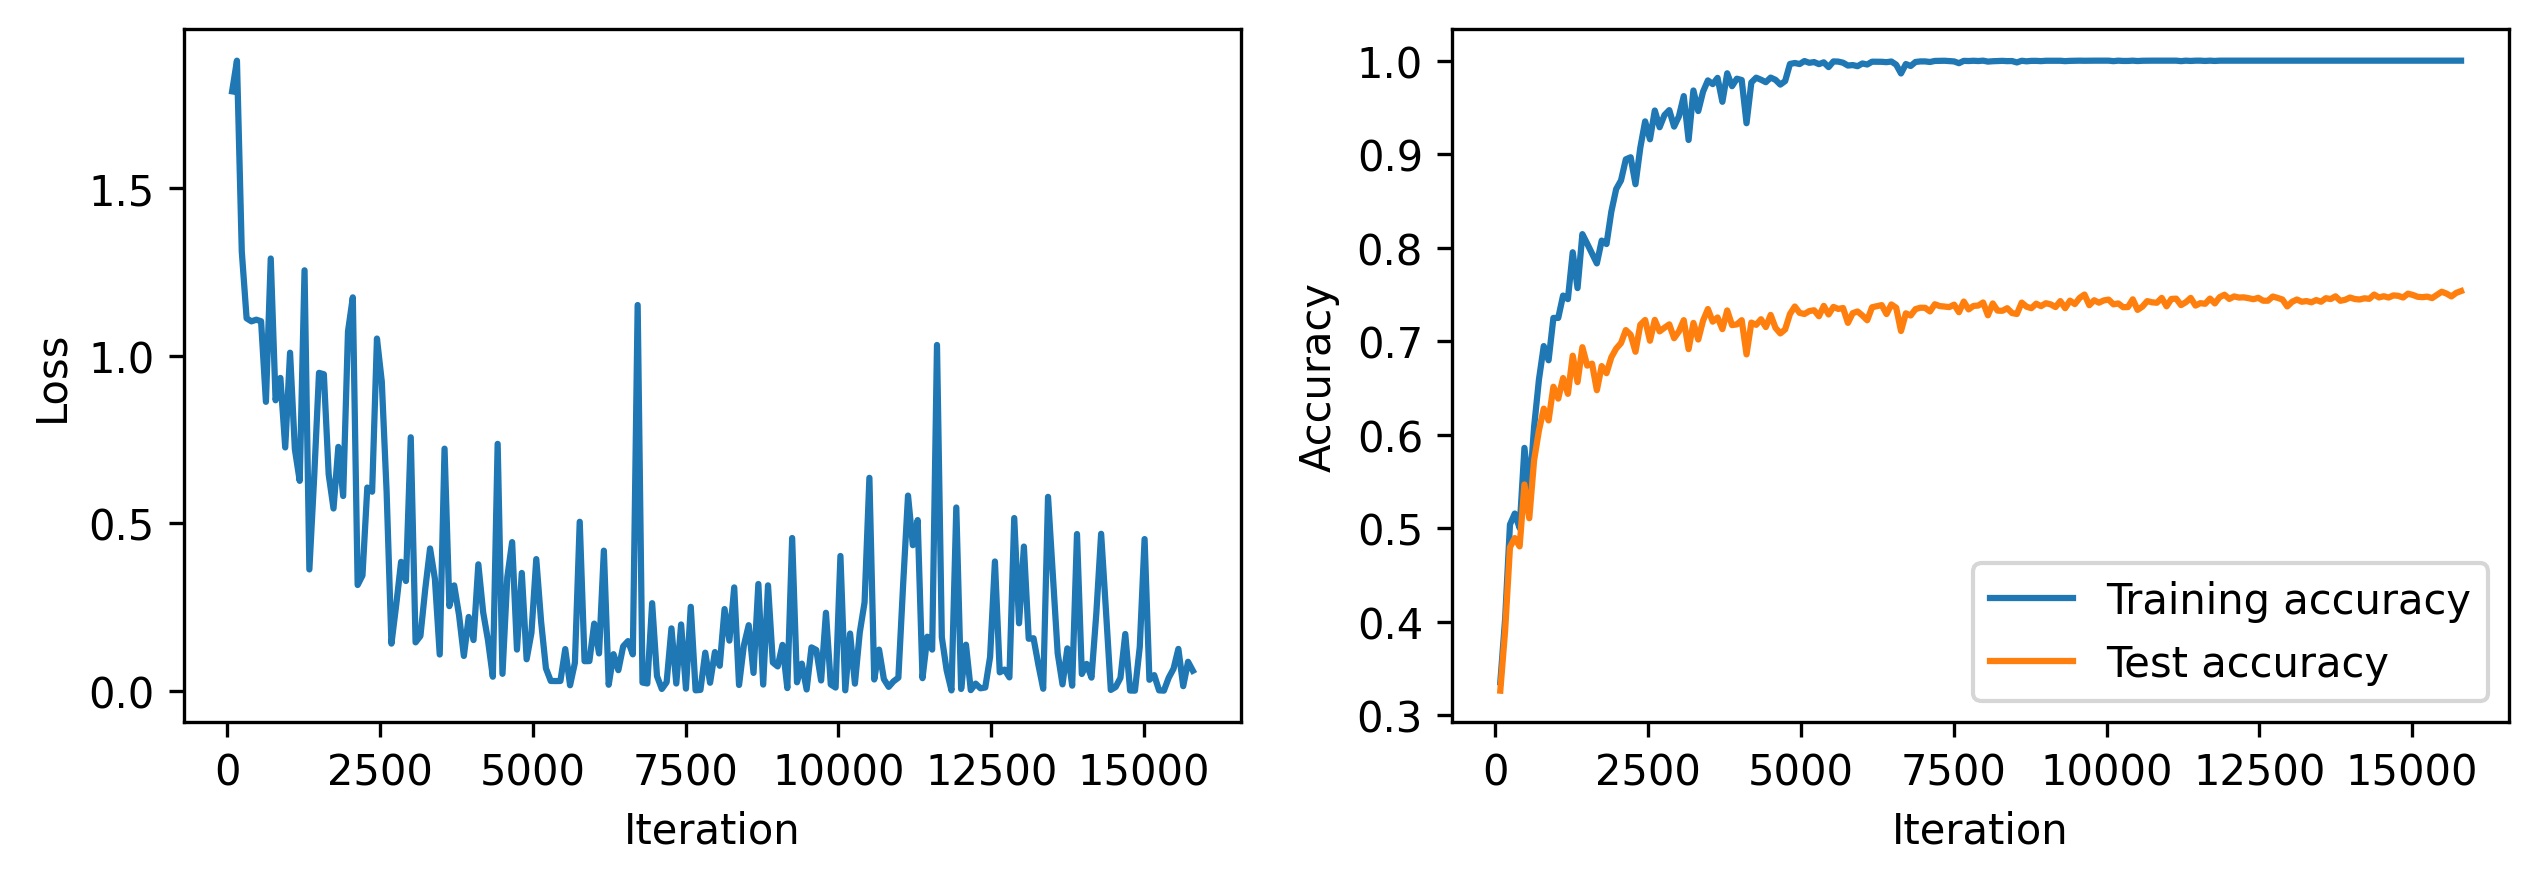

In [80]:
plot_la(ITRs, Loss, Acc_train, Acc_test)

## 2. Mixup augmentation

In [81]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def get_acc_mix(y1, y2, y_hat, lam):
    y1 = torch.max(y1, 1)[1]
    y2 = torch.max(y2, 1)[1]
    y_hat = torch.max(y_hat, 1)[1]
    acc = (lam * (y1==y_hat).sum() + (1 - lam) * (y2==y_hat).sum()) / len(y_hat)
    acc = acc.cpu()
    return acc

### 2.1 alpha = 0.2

In [82]:
alpha = 0.2
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        labels = labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(images, labels,alpha)
        inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            # training acc
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            # test acc
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
    # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *= decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 2.0379, Training acc: 0.3500, Test acc: 0.3437
epoch [2/200], Training Loss: 1.5005, Training acc: 0.4419, Test acc: 0.4285
epoch [3/200], Training Loss: 1.6877, Training acc: 0.4911, Test acc: 0.4685
epoch [4/200], Training Loss: 1.2253, Training acc: 0.5493, Test acc: 0.5217
epoch [5/200], Training Loss: 1.6800, Training acc: 0.5726, Test acc: 0.5351
epoch [6/200], Training Loss: 1.2416, Training acc: 0.5270, Test acc: 0.4921
epoch [7/200], Training Loss: 1.0656, Training acc: 0.5885, Test acc: 0.5509
epoch [8/200], Training Loss: 1.0969, Training acc: 0.6380, Test acc: 0.5905
epoch [9/200], Training Loss: 1.3334, Training acc: 0.6195, Test acc: 0.5679
epoch [10/200], Training Loss: 1.9650, Training acc: 0.6143, Test acc: 0.5754
epoch [11/200], Training Loss: 1.8881, Training acc: 0.6897, Test acc: 0.6259
epoch [12/200], Training Loss: 1.2864, Training acc: 0.6668, Test acc: 0.6028
epoch [13/200], Training Loss: 0.7225, Training acc: 0.7015, Test acc: 0.

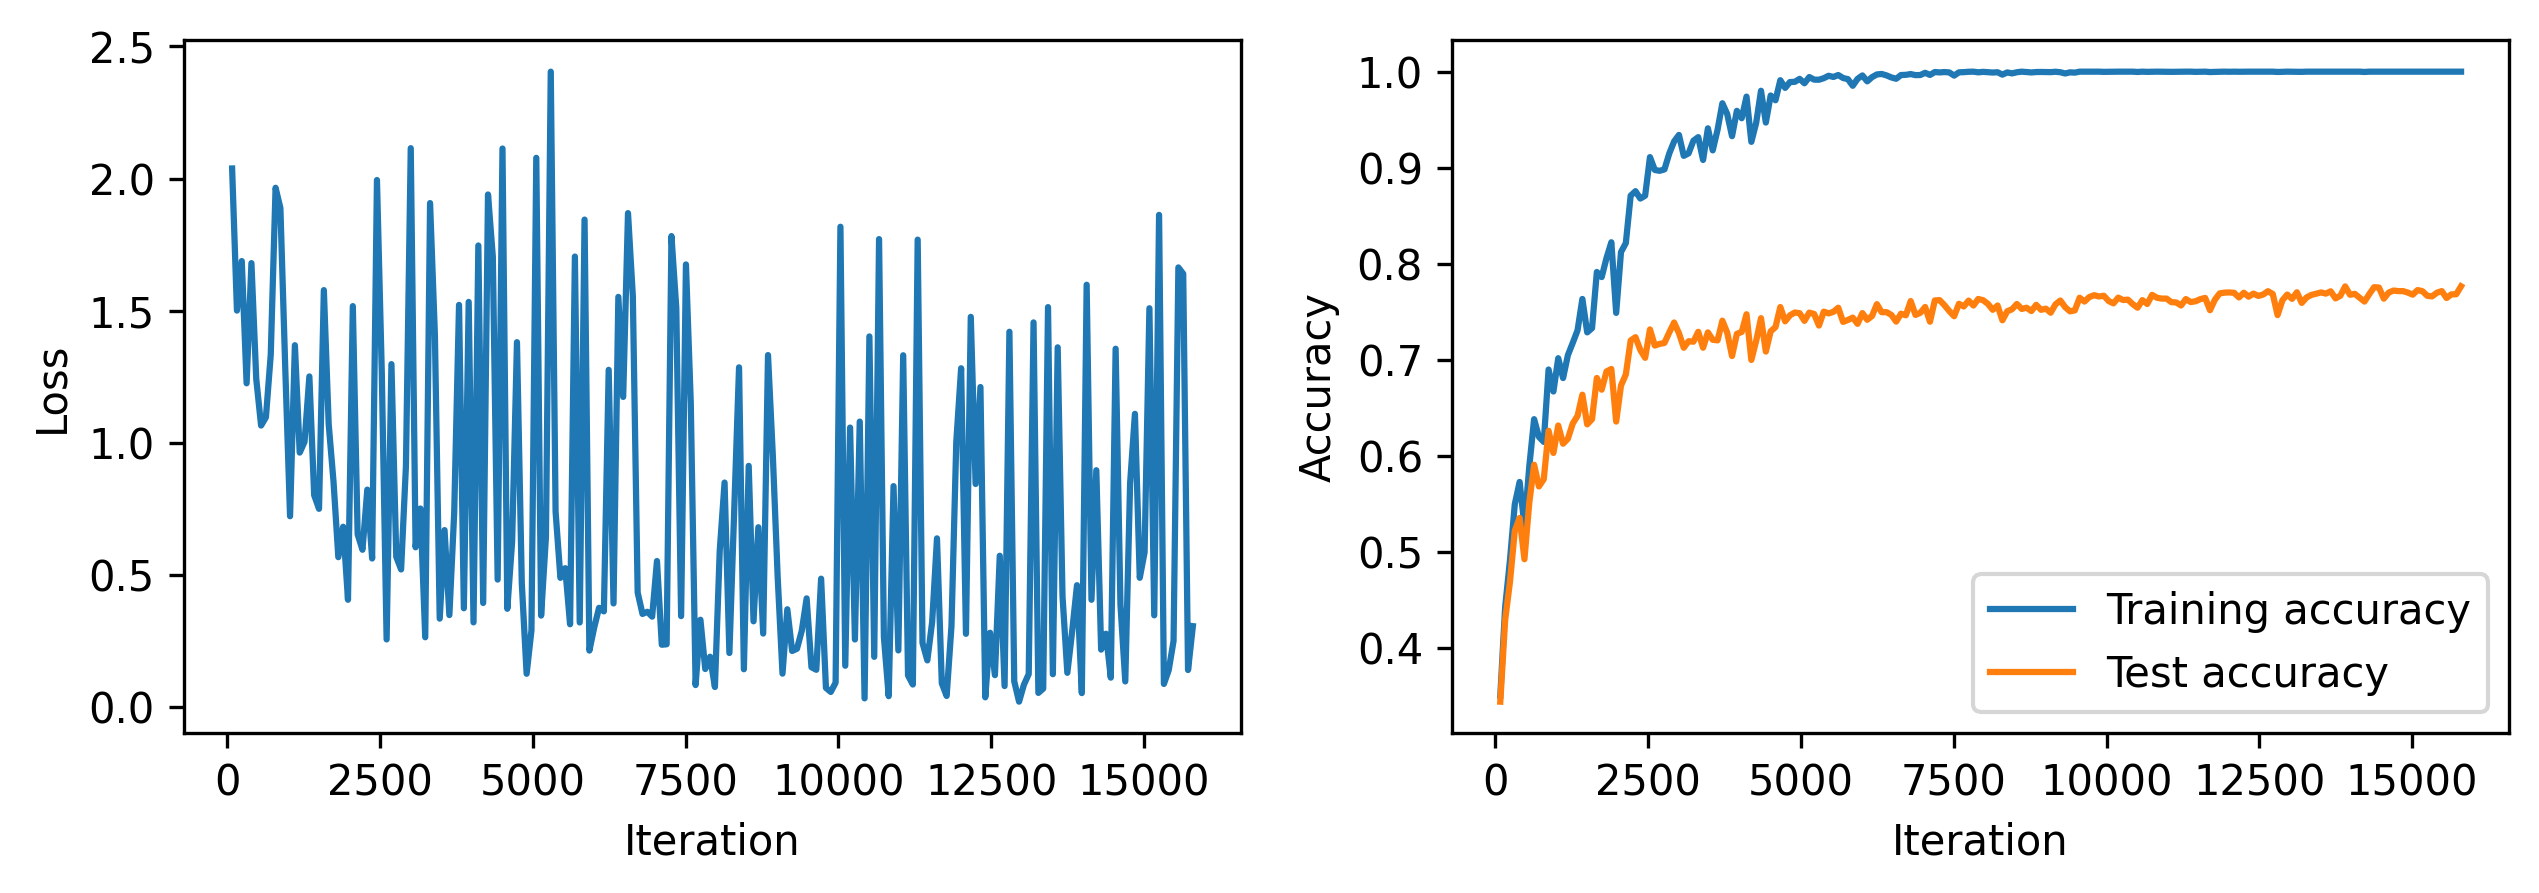

In [83]:
plot_la(ITRs, Loss, Acc_train, Acc_test)

### 2.2 alpha = 0.4

In [84]:
alpha = 0.4
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        labels = labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(images, labels,alpha)
        inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
    # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *= decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 1.7144, Training acc: 0.2881, Test acc: 0.2857
epoch [2/200], Training Loss: 1.5213, Training acc: 0.4193, Test acc: 0.4083
epoch [3/200], Training Loss: 1.9635, Training acc: 0.4721, Test acc: 0.4537
epoch [4/200], Training Loss: 1.3649, Training acc: 0.5146, Test acc: 0.4947
epoch [5/200], Training Loss: 1.2771, Training acc: 0.5375, Test acc: 0.5131
epoch [6/200], Training Loss: 1.3138, Training acc: 0.5364, Test acc: 0.5118
epoch [7/200], Training Loss: 1.1384, Training acc: 0.5943, Test acc: 0.5588
epoch [8/200], Training Loss: 1.0048, Training acc: 0.6432, Test acc: 0.6064
epoch [9/200], Training Loss: 0.9532, Training acc: 0.6765, Test acc: 0.6385
epoch [10/200], Training Loss: 1.8817, Training acc: 0.6899, Test acc: 0.6415
epoch [11/200], Training Loss: 1.1546, Training acc: 0.6705, Test acc: 0.6152
epoch [12/200], Training Loss: 0.9630, Training acc: 0.5661, Test acc: 0.5195
epoch [13/200], Training Loss: 1.8050, Training acc: 0.6312, Test acc: 0.

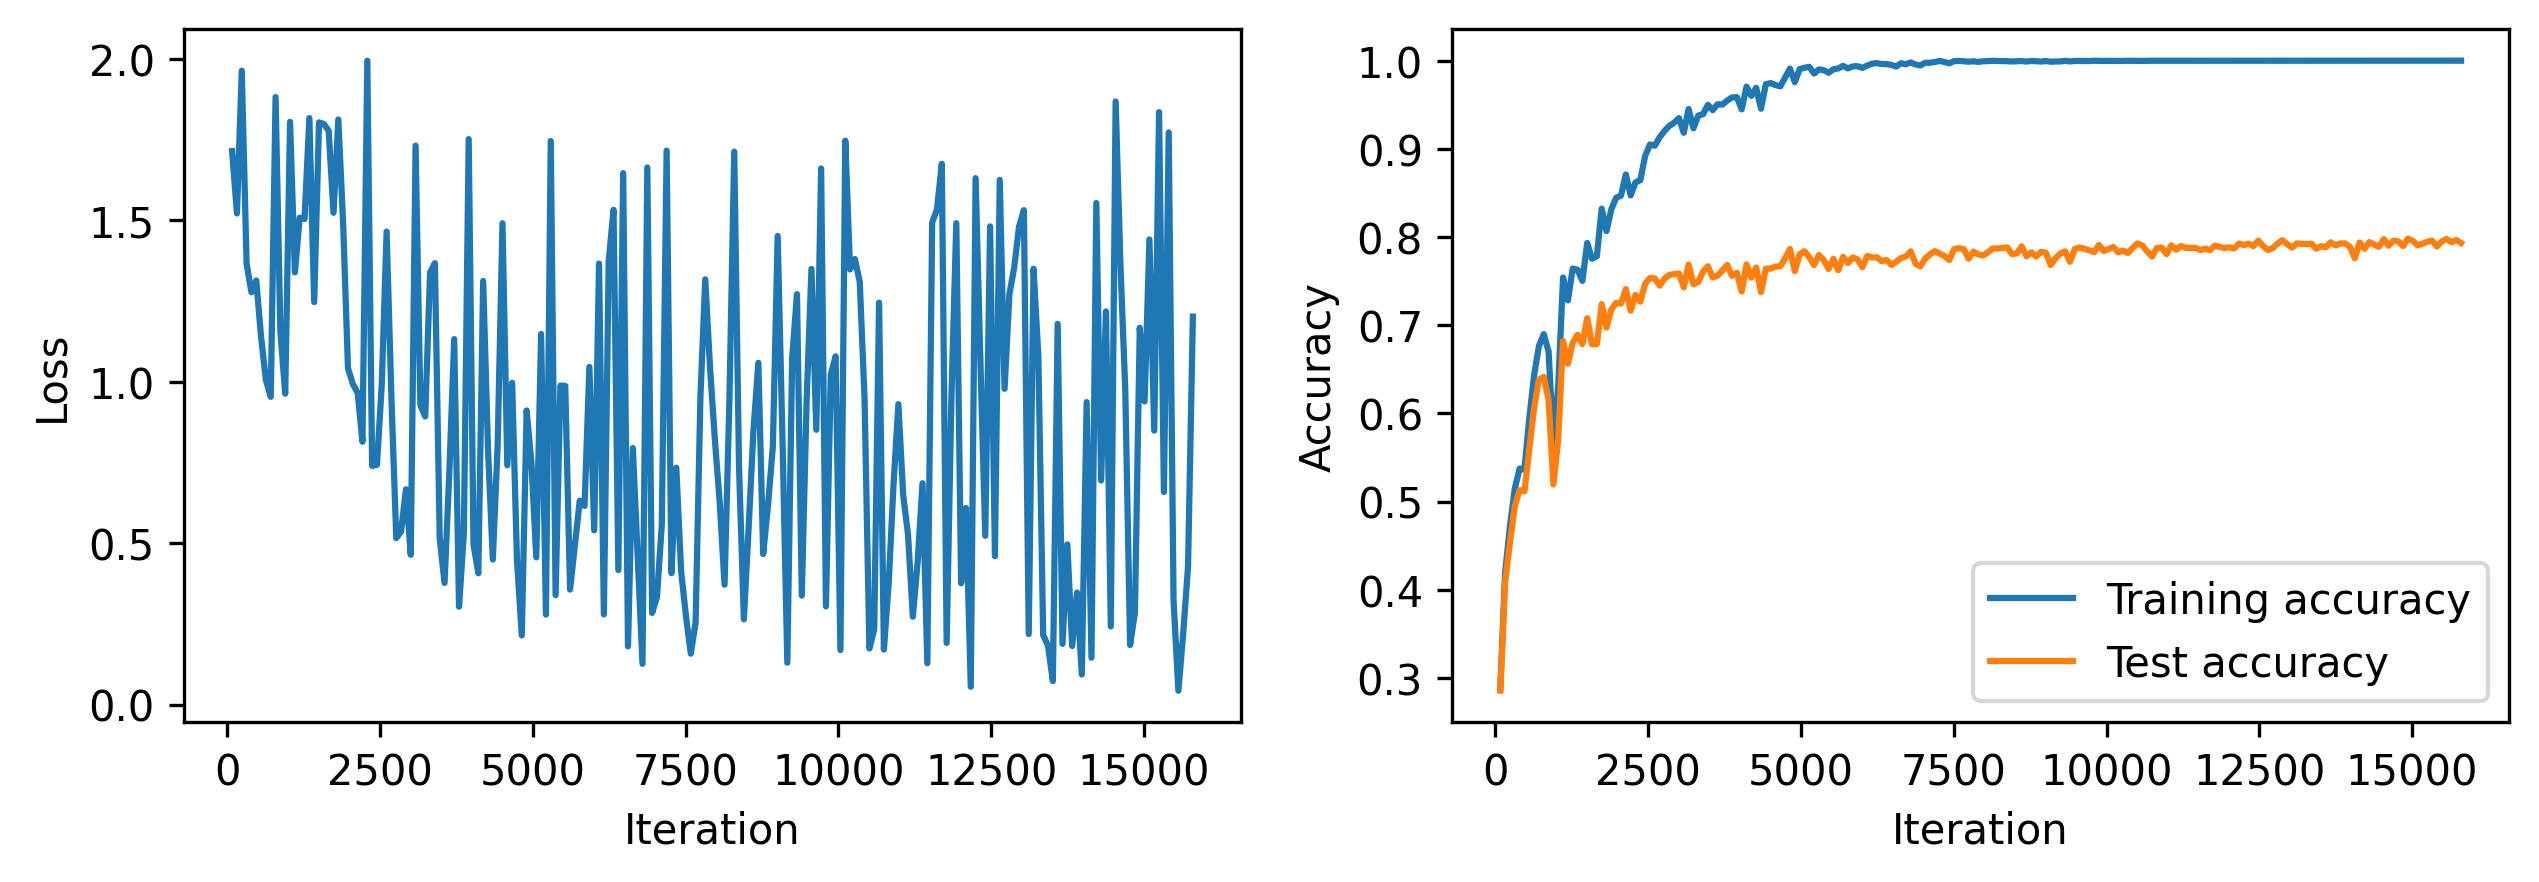

In [85]:
plot_la(ITRs, Loss, Acc_train, Acc_test)

##  3. Cutout Augmentation

In [86]:
def CutoutAug(imgs, size=16):
    if random.random() > 0.5:
        return imgs

    _, _,w, h = imgs.shape

    # Randomly select the center pixel for cutout
    center_x = random.randint(0, w)
    center_y = random.randint(0, h)
    half_size = size // 2

    # Calculate the coordinates for the cutout mask
    x1 = max(0, center_x - half_size)
    y1 = max(0, center_y - half_size)
    x2 = min(w, center_x + half_size)
    y2 = min(h, center_y + half_size)

    # Apply the cutout mask to the image
    imgs[:, :, x1:x2, y1:y2] = 0

    return imgs

In [87]:
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        images = CutoutAug(images)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
    # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *= decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 1.7087, Training acc: 0.2960, Test acc: 0.2909
epoch [2/200], Training Loss: 1.6029, Training acc: 0.4244, Test acc: 0.4212
epoch [3/200], Training Loss: 1.2340, Training acc: 0.4787, Test acc: 0.4603
epoch [4/200], Training Loss: 1.0567, Training acc: 0.5090, Test acc: 0.4902
epoch [5/200], Training Loss: 1.5905, Training acc: 0.5222, Test acc: 0.5086
epoch [6/200], Training Loss: 1.2234, Training acc: 0.4256, Test acc: 0.4047
epoch [7/200], Training Loss: 1.3482, Training acc: 0.5909, Test acc: 0.5678
epoch [8/200], Training Loss: 0.9747, Training acc: 0.5615, Test acc: 0.5286
epoch [9/200], Training Loss: 0.8894, Training acc: 0.6479, Test acc: 0.6044
epoch [10/200], Training Loss: 1.2927, Training acc: 0.6484, Test acc: 0.5998
epoch [11/200], Training Loss: 1.0642, Training acc: 0.6115, Test acc: 0.5674
epoch [12/200], Training Loss: 0.7097, Training acc: 0.6716, Test acc: 0.6183
epoch [13/200], Training Loss: 0.9787, Training acc: 0.6369, Test acc: 0.

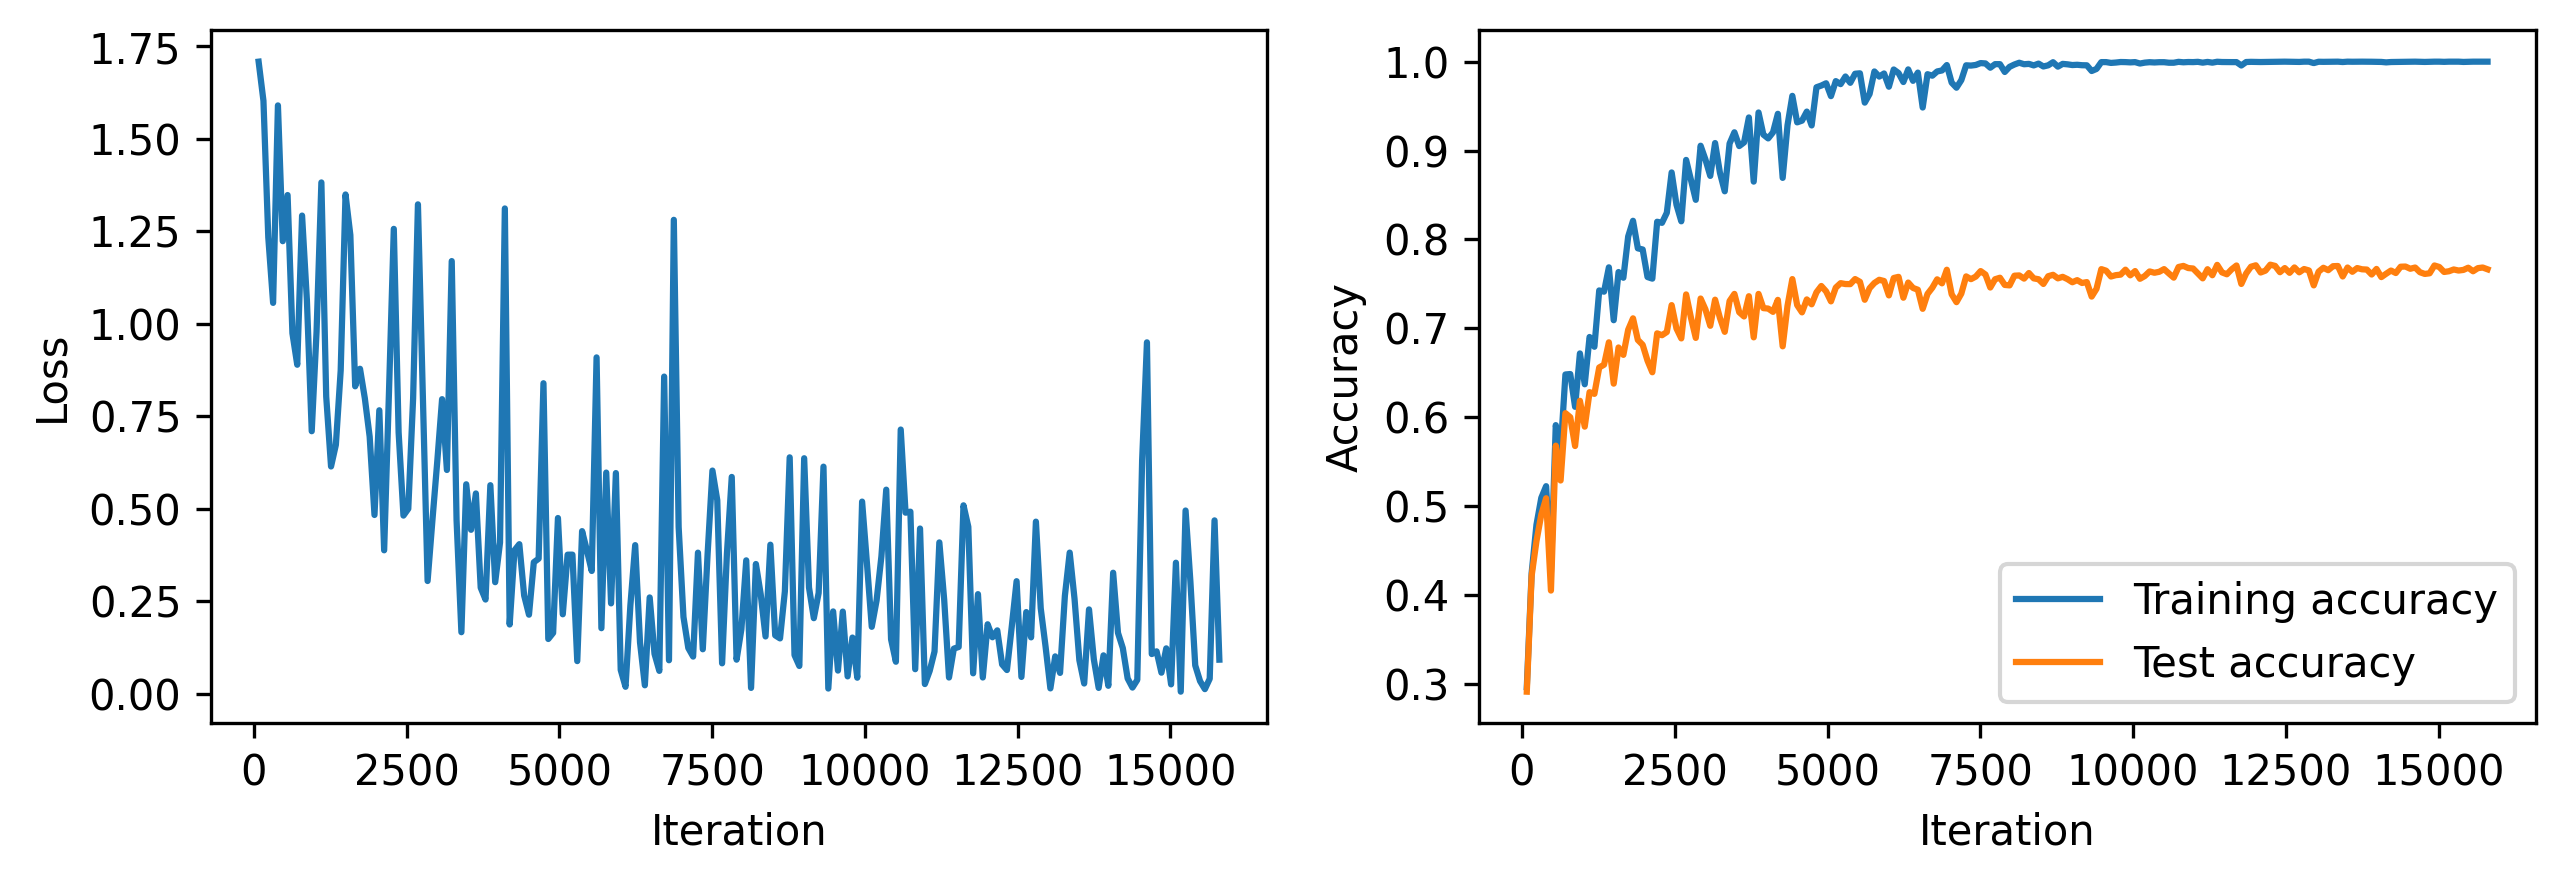

In [88]:
plot_la(ITRs, Loss, Acc_train, Acc_test)

## 4. Standard augmentation

In [89]:
def StandardAug(imgs):
    k1 = np.random.randint(-4,5)
    k2 = np.random.randint(-4,5)
    new_imgs = transforms.functional.pad(imgs, (4,4,4,4))
    new_imgs = transforms.functional.crop(new_imgs, k1+4, k2+4, 32,32)
    if torch.rand(1) < 0.5:
        new_imgs = transforms.functional.hflip(new_imgs)
    return new_imgs

In [90]:
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        images = StandardAug(images)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
    # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *=decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 1.7863, Training acc: 0.3525, Test acc: 0.3512
epoch [2/200], Training Loss: 1.7041, Training acc: 0.3923, Test acc: 0.3873
epoch [3/200], Training Loss: 1.8869, Training acc: 0.4024, Test acc: 0.3976
epoch [4/200], Training Loss: 1.4686, Training acc: 0.4566, Test acc: 0.4348
epoch [5/200], Training Loss: 1.1878, Training acc: 0.4996, Test acc: 0.4811
epoch [6/200], Training Loss: 1.7045, Training acc: 0.5211, Test acc: 0.5040
epoch [7/200], Training Loss: 1.0391, Training acc: 0.5102, Test acc: 0.5005
epoch [8/200], Training Loss: 1.6327, Training acc: 0.5521, Test acc: 0.5340
epoch [9/200], Training Loss: 1.2050, Training acc: 0.5666, Test acc: 0.5533
epoch [10/200], Training Loss: 0.8062, Training acc: 0.6136, Test acc: 0.5902
epoch [11/200], Training Loss: 1.2851, Training acc: 0.5944, Test acc: 0.5770
epoch [12/200], Training Loss: 1.1961, Training acc: 0.6357, Test acc: 0.6036
epoch [13/200], Training Loss: 1.2924, Training acc: 0.5908, Test acc: 0.

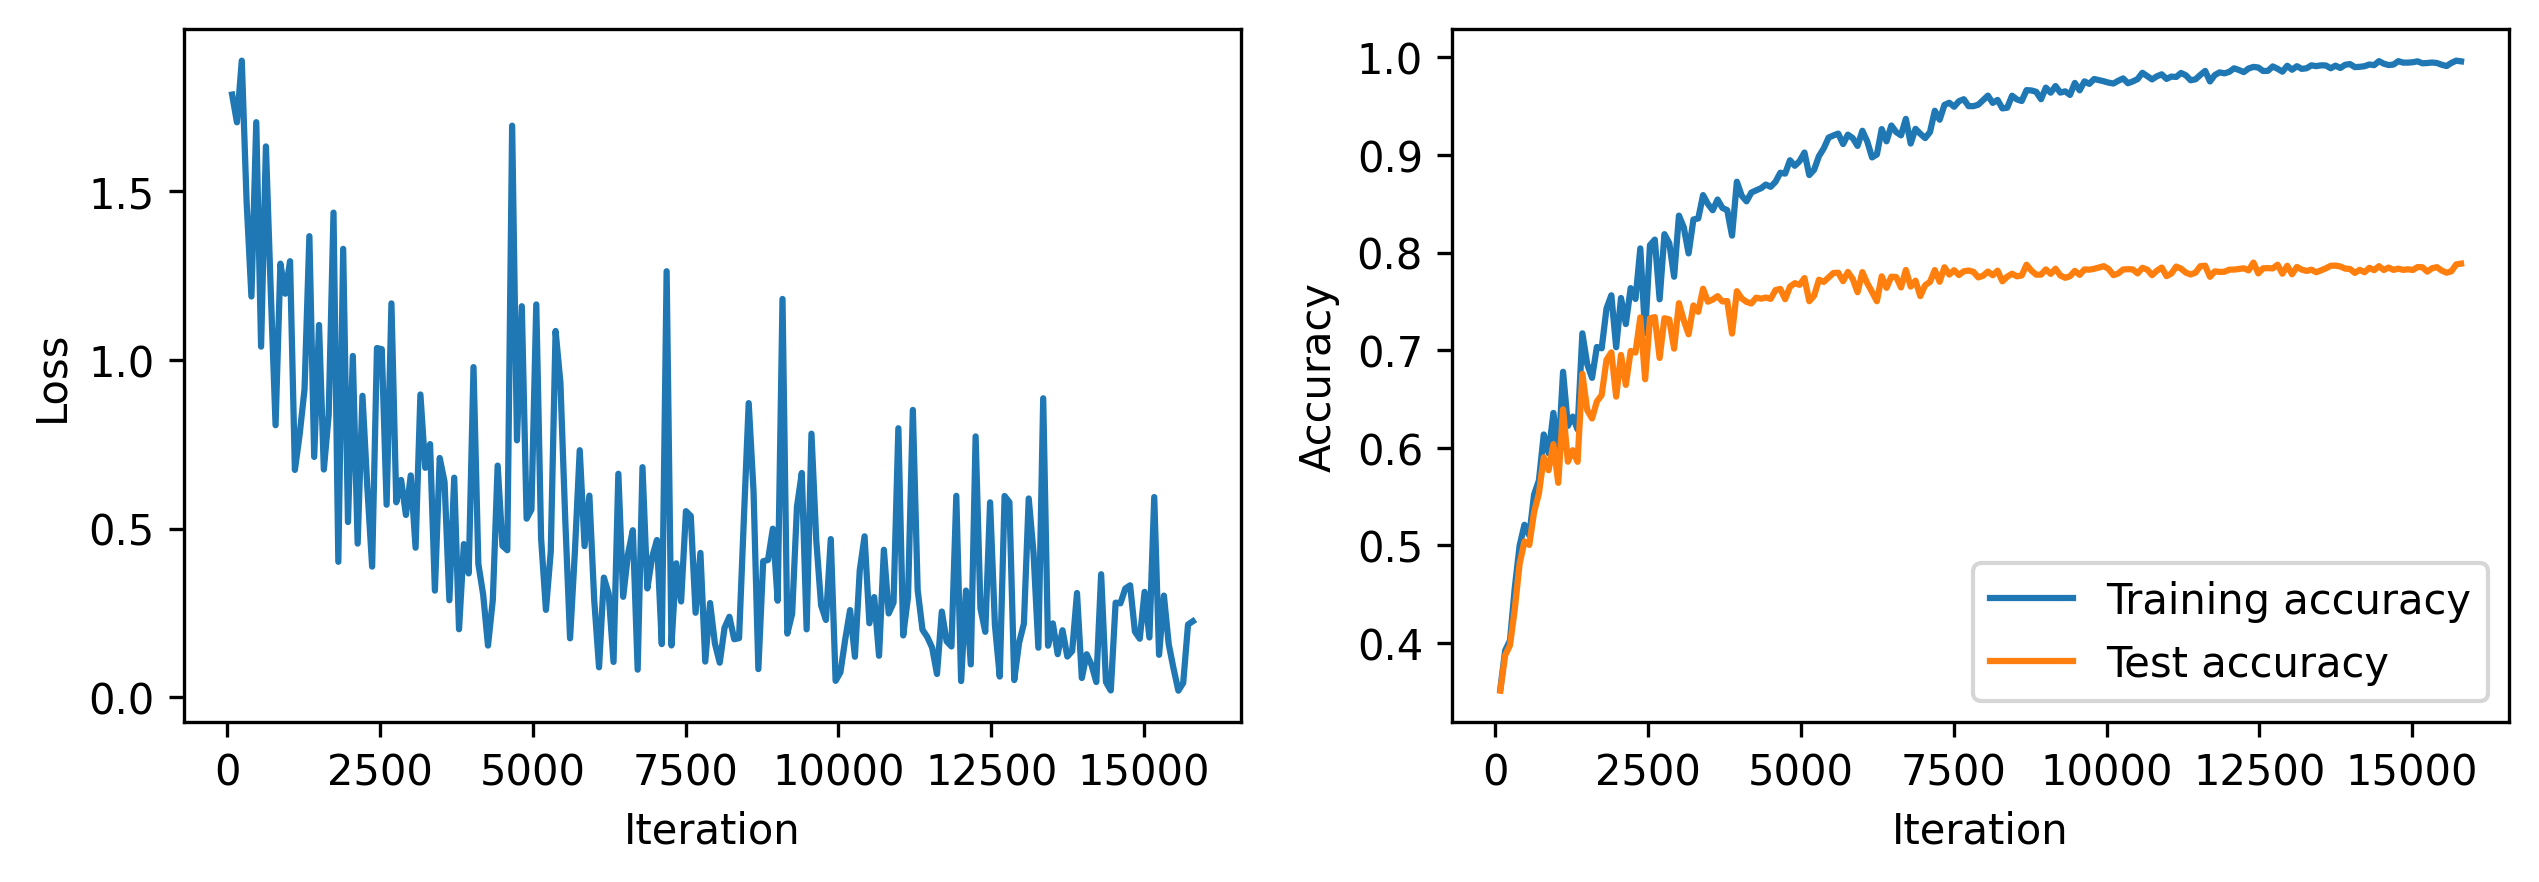

In [91]:
plot_la(ITRs, Loss, Acc_train, Acc_test)

## 5. Combine all the augmentations together

In [92]:
alpha = 0.4
model = ResNet20().to(device)
# model.eval();
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate

ITRs = []
Acc_train = []
Acc_test = []
Loss = []
ITR = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        ITR+=1
        images = images.to(device)
        images = StandardAug(images)
        images = CutoutAug(images)
        labels = labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(images, labels,alpha)
        inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # evalute model

    with torch.no_grad():
            model.eval()
            ITRs.append(ITR)
            Loss.append(loss.item())
            y_train_hat = model(X_train)
            acc_train = get_acc(y_train, y_train_hat)
            Acc_train.append(acc_train)
            y_test_hat = model(X_test)
            acc_test = get_acc(y_test, y_test_hat)
            Acc_test.append(acc_test)
            print(f"epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Training acc: {acc_train:.4f}, Test acc: {acc_test:.4f}")
            model.train()
    
    # Decay learning rate
    if (epoch+1) % 30 == 0:
        curr_lr *= decay_rate
        update_lr(optimizer, curr_lr)


epoch [1/200], Training Loss: 2.2517, Training acc: 0.3546, Test acc: 0.3509
epoch [2/200], Training Loss: 1.7312, Training acc: 0.3743, Test acc: 0.3757
epoch [3/200], Training Loss: 1.6669, Training acc: 0.3329, Test acc: 0.3310
epoch [4/200], Training Loss: 1.7911, Training acc: 0.4756, Test acc: 0.4671
epoch [5/200], Training Loss: 1.9429, Training acc: 0.5064, Test acc: 0.4954
epoch [6/200], Training Loss: 2.0884, Training acc: 0.5338, Test acc: 0.5126
epoch [7/200], Training Loss: 1.8915, Training acc: 0.5557, Test acc: 0.5457
epoch [8/200], Training Loss: 1.9510, Training acc: 0.5076, Test acc: 0.4951
epoch [9/200], Training Loss: 1.2261, Training acc: 0.5469, Test acc: 0.5240
epoch [10/200], Training Loss: 1.2147, Training acc: 0.5909, Test acc: 0.5711
epoch [11/200], Training Loss: 1.4063, Training acc: 0.5700, Test acc: 0.5544
epoch [12/200], Training Loss: 1.2755, Training acc: 0.6121, Test acc: 0.5912
epoch [13/200], Training Loss: 0.9161, Training acc: 0.6233, Test acc: 0.

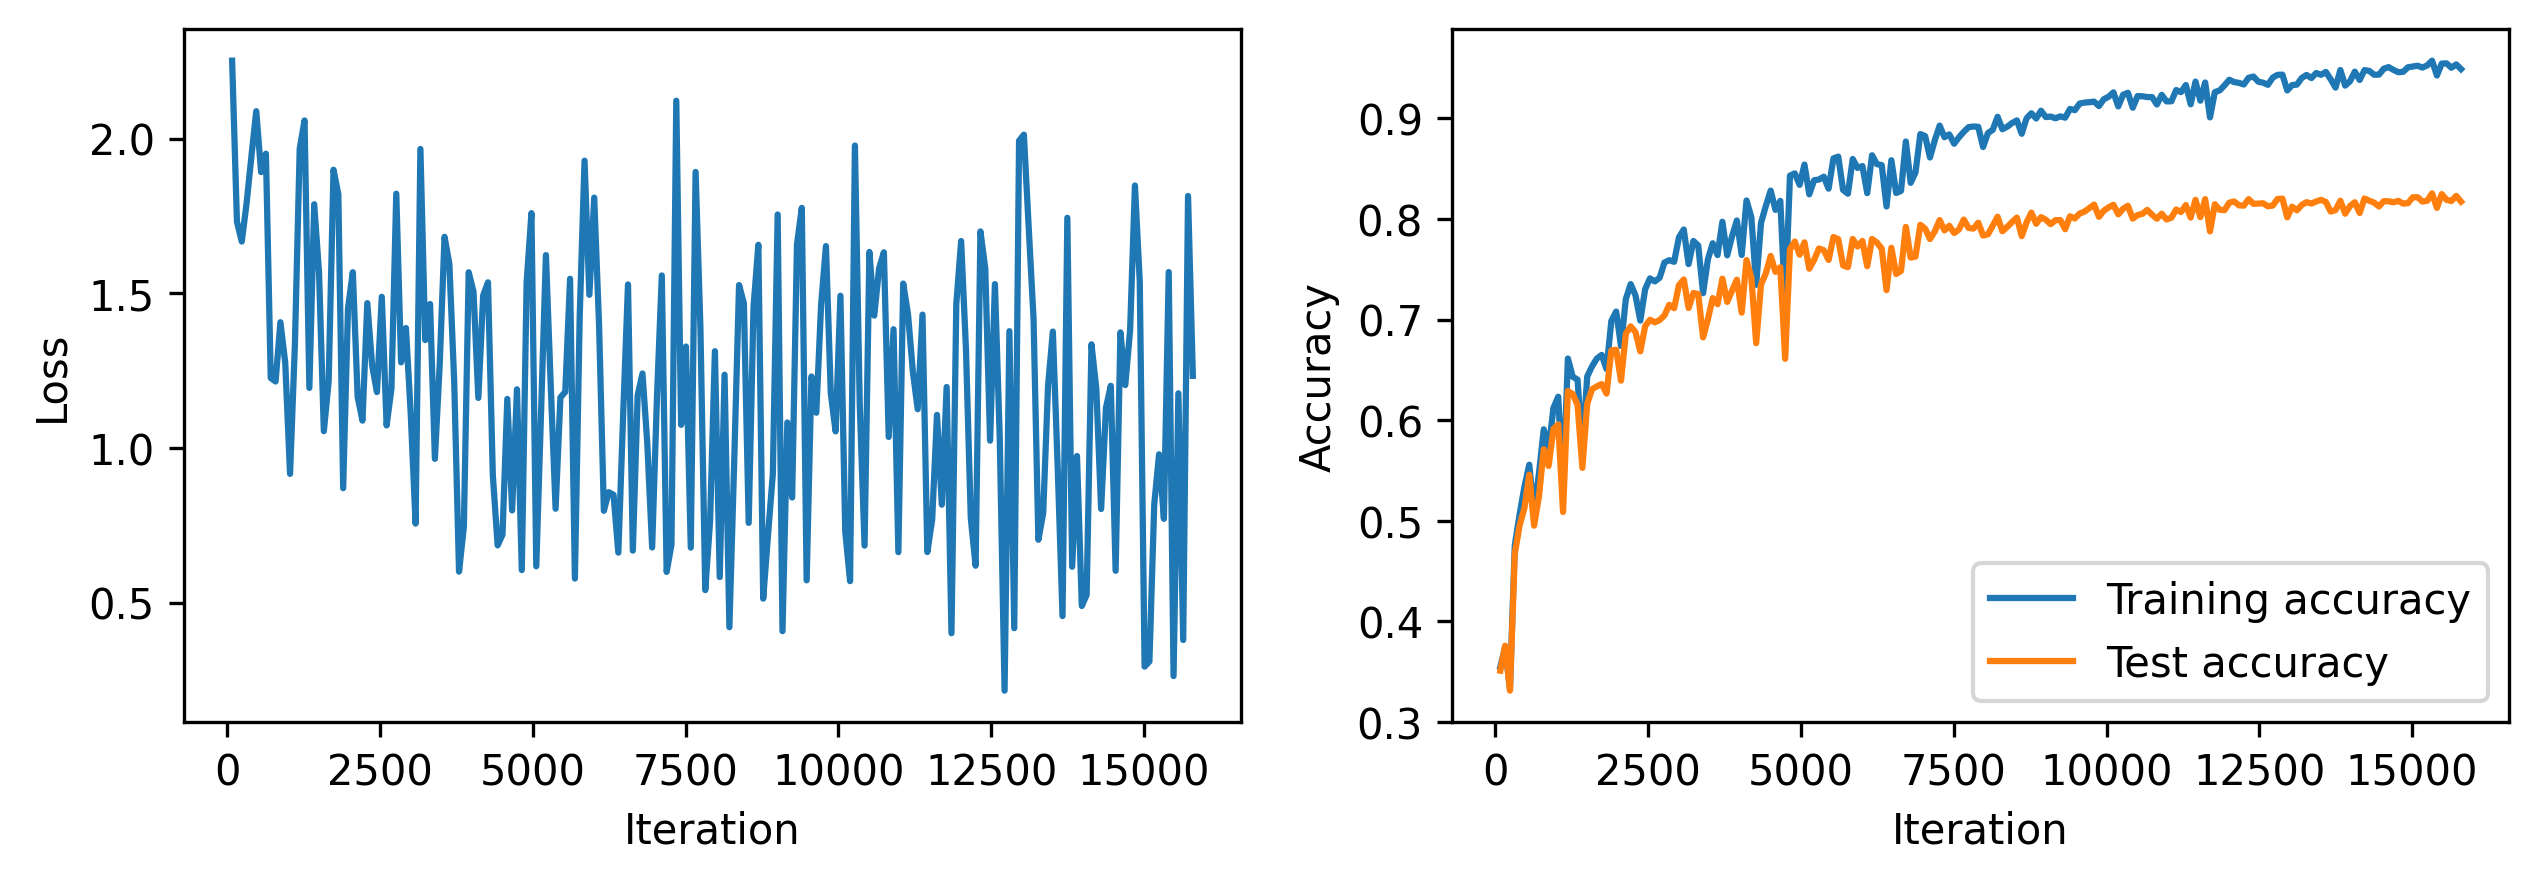

In [93]:
plot_la(ITRs, Loss, Acc_train, Acc_test)